In [1]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from torchsummary import summary
from torch import nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
data = pd.read_csv('HDFC.csv')
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,HDFC,EQ,271.75,293.5,293.50,293.5,293.5,293.50,293.50,22744,6.675364e+11,NaN,NaN,NaN
1,2000-01-04,HDFC,EQ,293.50,317.0,317.00,297.0,304.0,304.05,303.62,255251,7.749972e+12,NaN,NaN,NaN
2,2000-01-05,HDFC,EQ,304.05,290.0,303.90,285.0,295.0,292.80,294.53,269087,7.925368e+12,NaN,NaN,NaN
3,2000-01-06,HDFC,EQ,292.80,301.0,314.00,295.0,296.0,296.45,300.14,305916,9.181669e+12,NaN,NaN,NaN
4,2000-01-07,HDFC,EQ,296.45,290.0,296.35,281.0,287.1,286.55,288.80,197039,5.690480e+12,NaN,NaN,NaN


In [4]:
stock_values = data['Close'].values
mu = stock_values.mean()
sigma = stock_values.std()
stock_values = (stock_values-mu)/sigma

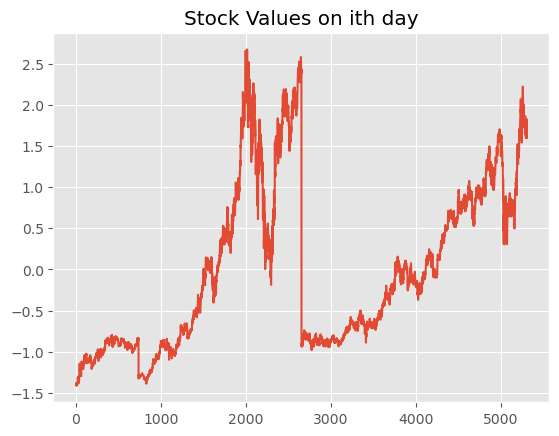

In [5]:
style.use('ggplot')
plt.plot(range(1,stock_values.shape[0]+1), stock_values)
plt.title("Stock Values on ith day")
plt.show()

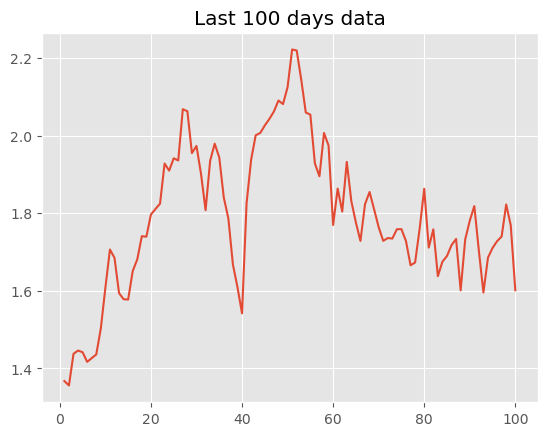

In [6]:
## let us analyze the data of last 100 days
slice_ = stock_values[-100:]
style.use('ggplot')
plt.plot(range(1, 101), slice_)
plt.title("Last 100 days data")
plt.show()

* Let us make it a regression problem by sliding windows
* Let us assume that our price of stock on current day depend upon past 100 days

In [7]:
def sliding_windows(window_len, data):
    x = []
    y = []
    for i in range(data.shape[0]):
        if i+window_len+1<data.shape[0]:
            x.append(data[i:i+window_len])
            y.append(data[i+window_len+1])
    return np.array(x), np.array(y)
            

In [8]:
class net(nn.Module):
    def __init__(self, in_features=100):
        super(net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.Tanh(),
            #nn.Dropout(), #  just to prevent overfitting 
            nn.Linear(64, 1)) 
    
    def forward(self, x):
        # x must be of shape 
        return self.fc(x)

In [9]:
summary(net(), (100, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           6,464
              Tanh-2                   [-1, 64]               0
            Linear-3                    [-1, 1]              65
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


* Basically our data has 100 features and now it can be posed as a simple regression problem 

In [10]:
# first forming the data
batch_size = 32
window_len = 100
x, y = sliding_windows(window_len, stock_values)

# dataloaders
dataset = np.concatenate((x, y.reshape(y.shape[0], 1)), axis=1)
dataset = torch.tensor(dataset, dtype=torch.float32)
#train_data, test_data = torch.utils.data.random_split(dataset, [4164, 1041])
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


# defining the model 
epochs = 200
model = net(in_features=window_len).to(device)
lr = 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

In [11]:
def train(epoch, batch_size = 32, print_every = 50):
  total_loss = 0 # average of losses over all of the batches

  for i, batch in enumerate(train_loader,1):  # i represents number of batches starting from 1
    model_input = (batch[:,:-1]).to(device)
    #print(model_input.shape)
    target = (batch[:,-1]).to(device)
    #print(target.shape)
    model_output = model(model_input)
    loss = loss_fn(model_output.reshape(target.shape[0]), target)
    total_loss+= loss.item()  # as it is just a tensor of 0 dimension, so converting it to a scalar by .item() method
    # backpropoagation
    optimizer.zero_grad() # making the gradients equal to zero if there are previously any
    loss.backward()
    optimizer.step()  # updating the gradients

    if i%print_every==0:   # should print something after every 'print_every' no. of batches are processed
      print('Epoch [{}] ({}/{}), train_loss = {:.4f}'.format(epoch, i, len(train_loader), loss.item()))
  return total_loss/len(train_loader) # returns average loss of all batches


In [12]:
losses = []
model.train()
for epoch in range(epochs):
    losses.append(train(epoch))
    print("\n")

Epoch [0] (50/162), train_loss = 0.2162
Epoch [0] (100/162), train_loss = 0.0063
Epoch [0] (150/162), train_loss = 0.0114


Epoch [1] (50/162), train_loss = 0.0055
Epoch [1] (100/162), train_loss = 0.0046
Epoch [1] (150/162), train_loss = 0.0224


Epoch [2] (50/162), train_loss = 0.0144
Epoch [2] (100/162), train_loss = 0.0108
Epoch [2] (150/162), train_loss = 0.0076


Epoch [3] (50/162), train_loss = 0.0044
Epoch [3] (100/162), train_loss = 0.0101
Epoch [3] (150/162), train_loss = 0.0072


Epoch [4] (50/162), train_loss = 0.0111
Epoch [4] (100/162), train_loss = 0.0028
Epoch [4] (150/162), train_loss = 0.0022


Epoch [5] (50/162), train_loss = 0.0080
Epoch [5] (100/162), train_loss = 0.0031
Epoch [5] (150/162), train_loss = 0.0086


Epoch [6] (50/162), train_loss = 0.0059
Epoch [6] (100/162), train_loss = 0.0132
Epoch [6] (150/162), train_loss = 0.0050


Epoch [7] (50/162), train_loss = 0.0079
Epoch [7] (100/162), train_loss = 0.0084
Epoch [7] (150/162), train_loss = 0.0100


Epoch [8

Epoch [65] (100/162), train_loss = 0.0023
Epoch [65] (150/162), train_loss = 0.0088


Epoch [66] (50/162), train_loss = 0.0061
Epoch [66] (100/162), train_loss = 0.0079
Epoch [66] (150/162), train_loss = 0.0084


Epoch [67] (50/162), train_loss = 0.0069
Epoch [67] (100/162), train_loss = 0.0111
Epoch [67] (150/162), train_loss = 0.0065


Epoch [68] (50/162), train_loss = 0.0024
Epoch [68] (100/162), train_loss = 0.0054
Epoch [68] (150/162), train_loss = 0.0053


Epoch [69] (50/162), train_loss = 0.0031
Epoch [69] (100/162), train_loss = 0.0063
Epoch [69] (150/162), train_loss = 0.0061


Epoch [70] (50/162), train_loss = 0.0134
Epoch [70] (100/162), train_loss = 0.0097
Epoch [70] (150/162), train_loss = 0.0123


Epoch [71] (50/162), train_loss = 0.0058
Epoch [71] (100/162), train_loss = 0.0055
Epoch [71] (150/162), train_loss = 0.0137


Epoch [72] (50/162), train_loss = 0.0062
Epoch [72] (100/162), train_loss = 0.0061
Epoch [72] (150/162), train_loss = 0.0099


Epoch [73] (50/162), trai

Epoch [130] (100/162), train_loss = 0.0077
Epoch [130] (150/162), train_loss = 0.0052


Epoch [131] (50/162), train_loss = 0.0024
Epoch [131] (100/162), train_loss = 0.0054
Epoch [131] (150/162), train_loss = 0.0051


Epoch [132] (50/162), train_loss = 0.0079
Epoch [132] (100/162), train_loss = 0.0076
Epoch [132] (150/162), train_loss = 0.0102


Epoch [133] (50/162), train_loss = 0.0047
Epoch [133] (100/162), train_loss = 0.0076
Epoch [133] (150/162), train_loss = 0.0025


Epoch [134] (50/162), train_loss = 0.0038
Epoch [134] (100/162), train_loss = 0.0077
Epoch [134] (150/162), train_loss = 0.0028


Epoch [135] (50/162), train_loss = 0.0037
Epoch [135] (100/162), train_loss = 0.0045
Epoch [135] (150/162), train_loss = 0.0066


Epoch [136] (50/162), train_loss = 0.0033
Epoch [136] (100/162), train_loss = 0.0047
Epoch [136] (150/162), train_loss = 0.0099


Epoch [137] (50/162), train_loss = 0.0024
Epoch [137] (100/162), train_loss = 0.0049
Epoch [137] (150/162), train_loss = 0.0049


Ep

Epoch [194] (100/162), train_loss = 0.0038
Epoch [194] (150/162), train_loss = 0.0046


Epoch [195] (50/162), train_loss = 0.0041
Epoch [195] (100/162), train_loss = 0.0037
Epoch [195] (150/162), train_loss = 0.0053


Epoch [196] (50/162), train_loss = 0.0022
Epoch [196] (100/162), train_loss = 0.0031
Epoch [196] (150/162), train_loss = 0.0061


Epoch [197] (50/162), train_loss = 0.0092
Epoch [197] (100/162), train_loss = 0.0092
Epoch [197] (150/162), train_loss = 0.0031


Epoch [198] (50/162), train_loss = 0.0037
Epoch [198] (100/162), train_loss = 0.0045
Epoch [198] (150/162), train_loss = 0.0054


Epoch [199] (50/162), train_loss = 0.0119
Epoch [199] (100/162), train_loss = 0.0059
Epoch [199] (150/162), train_loss = 0.0060




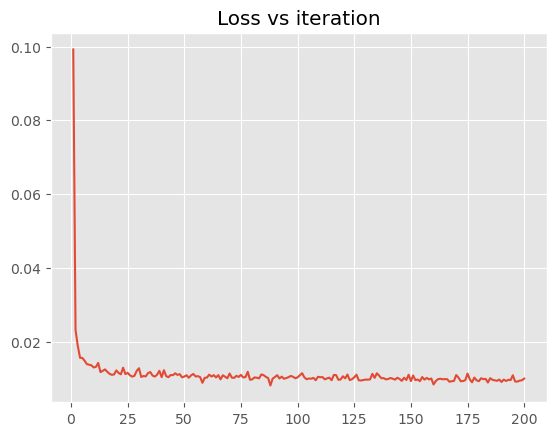

In [13]:
style.use('ggplot')
plt.plot(range(1, epochs+1), losses)
plt.title("Loss vs iteration")
plt.show()

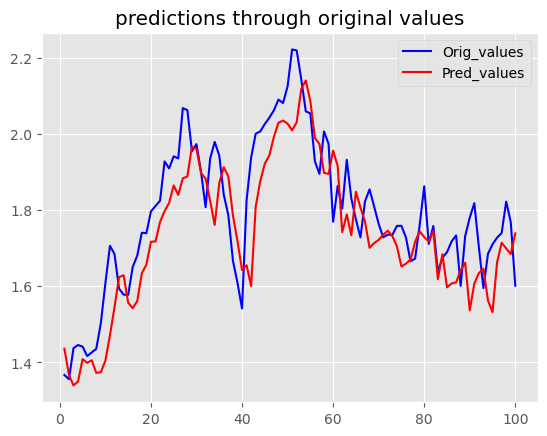

In [14]:
model.eval()
preds = torch.tensor(x,  dtype=torch.float32).to(device)
preds = model(preds).detach().numpy()
preds = preds.reshape(preds.shape[0])

style.use('ggplot')
plt.plot(range(1, 101), y[-100:], 'b')
plt.plot(range(1, 101), preds[-100:], 'r')
plt.title("predictions through original values")
plt.legend(['Orig_values', 'Pred_values'])
plt.show()

In [15]:
# predictions on last 100 of the sequence
def forecast(index=-200, window_len=100, num_samples=100):
    init_data = torch.tensor(stock_values[index:index+window_len], dtype=torch.float32).to(device)
    init_data = torch.reshape(init_data, (1, window_len))
    predictions = []
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            pred = model(init_data) # shape will be (1,1)
            predictions.append(pred[0][0].item())
            init_data = torch.cat([init_data[:, 1:], pred], axis=1)
    return predictions

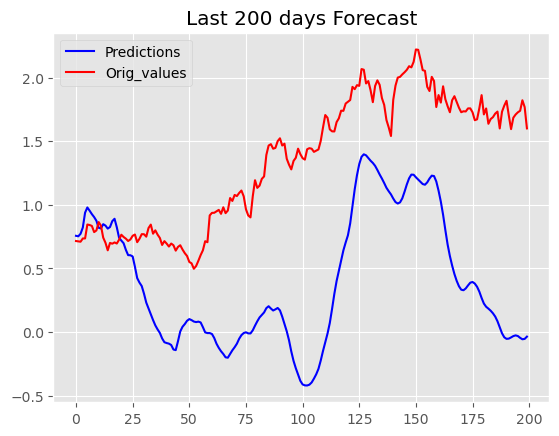

In [16]:
index, window_len, num_samples = -300, 100, 200 # index = -(window_len + num_samples)
predictions = forecast(index, window_len, num_samples)
slice_ = stock_values[-num_samples:]

style.use('ggplot')
plt.plot(range(num_samples), predictions, 'b')
plt.plot(range(num_samples), slice_, 'r')
plt.title(f"Last {num_samples} days Forecast")
plt.legend(['Predictions', 'Orig_values'])
plt.show()

* Clearly model can't forecast with great accuracy, clearly this isn't a great model, but we have a method to tackle sequential data

* Now let us try the sequence length to be 20 (i guess it is a good assumption that factors affecting prices of stock remain constant over past 20 days (in this we we get more training data, and less features, so i guess training should be better.

In [17]:
# first forming the data
batch_size = 32
window_len = 20
x, y = sliding_windows(window_len, stock_values)

# dataloaders
dataset = np.concatenate((x, y.reshape(y.shape[0], 1)), axis=1)
dataset = torch.tensor(dataset, dtype=torch.float32)
#train_data, test_data = torch.utils.data.random_split(dataset, [4164, 1041])
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


# defining the model 
epochs = 200
model = net(in_features=window_len).to(device)
lr = 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

In [18]:
losses = []
model.train()
for epoch in range(epochs):
    losses.append(train(epoch))
    print("\n")

Epoch [0] (50/165), train_loss = 0.0227
Epoch [0] (100/165), train_loss = 0.0340
Epoch [0] (150/165), train_loss = 0.0154


Epoch [1] (50/165), train_loss = 0.0089
Epoch [1] (100/165), train_loss = 0.0073
Epoch [1] (150/165), train_loss = 0.0067


Epoch [2] (50/165), train_loss = 0.0067
Epoch [2] (100/165), train_loss = 0.0053
Epoch [2] (150/165), train_loss = 0.0042


Epoch [3] (50/165), train_loss = 0.0045
Epoch [3] (100/165), train_loss = 0.0076
Epoch [3] (150/165), train_loss = 0.0090


Epoch [4] (50/165), train_loss = 0.0114
Epoch [4] (100/165), train_loss = 0.0079
Epoch [4] (150/165), train_loss = 0.0021


Epoch [5] (50/165), train_loss = 0.0053
Epoch [5] (100/165), train_loss = 0.0064
Epoch [5] (150/165), train_loss = 0.0066


Epoch [6] (50/165), train_loss = 0.0059
Epoch [6] (100/165), train_loss = 0.0048
Epoch [6] (150/165), train_loss = 0.0023


Epoch [7] (50/165), train_loss = 0.0030
Epoch [7] (100/165), train_loss = 0.0048
Epoch [7] (150/165), train_loss = 0.0058


Epoch [8

Epoch [65] (50/165), train_loss = 0.0071
Epoch [65] (100/165), train_loss = 0.0064
Epoch [65] (150/165), train_loss = 0.0026


Epoch [66] (50/165), train_loss = 0.0079
Epoch [66] (100/165), train_loss = 0.0080
Epoch [66] (150/165), train_loss = 0.0062


Epoch [67] (50/165), train_loss = 0.0100
Epoch [67] (100/165), train_loss = 0.0045
Epoch [67] (150/165), train_loss = 0.0048


Epoch [68] (50/165), train_loss = 0.0094
Epoch [68] (100/165), train_loss = 0.0016
Epoch [68] (150/165), train_loss = 0.0089


Epoch [69] (50/165), train_loss = 0.0038
Epoch [69] (100/165), train_loss = 0.0029
Epoch [69] (150/165), train_loss = 0.0053


Epoch [70] (50/165), train_loss = 0.0023
Epoch [70] (100/165), train_loss = 0.0078
Epoch [70] (150/165), train_loss = 0.0065


Epoch [71] (50/165), train_loss = 0.0014
Epoch [71] (100/165), train_loss = 0.0048
Epoch [71] (150/165), train_loss = 0.0026


Epoch [72] (50/165), train_loss = 0.0083
Epoch [72] (100/165), train_loss = 0.0067
Epoch [72] (150/165), train_



Epoch [130] (50/165), train_loss = 0.0043
Epoch [130] (100/165), train_loss = 0.0053
Epoch [130] (150/165), train_loss = 0.0024


Epoch [131] (50/165), train_loss = 0.0051
Epoch [131] (100/165), train_loss = 0.0027
Epoch [131] (150/165), train_loss = 0.0112


Epoch [132] (50/165), train_loss = 0.0130
Epoch [132] (100/165), train_loss = 0.0043
Epoch [132] (150/165), train_loss = 0.0041


Epoch [133] (50/165), train_loss = 0.0019
Epoch [133] (100/165), train_loss = 0.0074
Epoch [133] (150/165), train_loss = 0.0061


Epoch [134] (50/165), train_loss = 0.0085
Epoch [134] (100/165), train_loss = 0.0035
Epoch [134] (150/165), train_loss = 0.0035


Epoch [135] (50/165), train_loss = 0.0017
Epoch [135] (100/165), train_loss = 0.0048
Epoch [135] (150/165), train_loss = 0.0059


Epoch [136] (50/165), train_loss = 0.0030
Epoch [136] (100/165), train_loss = 0.0055
Epoch [136] (150/165), train_loss = 0.0020


Epoch [137] (50/165), train_loss = 0.0045
Epoch [137] (100/165), train_loss = 0.0033
Epo

Epoch [193] (150/165), train_loss = 0.0067


Epoch [194] (50/165), train_loss = 0.0019
Epoch [194] (100/165), train_loss = 0.0116
Epoch [194] (150/165), train_loss = 0.0070


Epoch [195] (50/165), train_loss = 0.0046
Epoch [195] (100/165), train_loss = 0.0098
Epoch [195] (150/165), train_loss = 0.0014


Epoch [196] (50/165), train_loss = 0.0034
Epoch [196] (100/165), train_loss = 0.0071
Epoch [196] (150/165), train_loss = 0.0041


Epoch [197] (50/165), train_loss = 0.0039
Epoch [197] (100/165), train_loss = 0.0039
Epoch [197] (150/165), train_loss = 0.0069


Epoch [198] (50/165), train_loss = 0.0033
Epoch [198] (100/165), train_loss = 0.0092
Epoch [198] (150/165), train_loss = 0.0088


Epoch [199] (50/165), train_loss = 0.0052
Epoch [199] (100/165), train_loss = 0.0044
Epoch [199] (150/165), train_loss = 0.0052




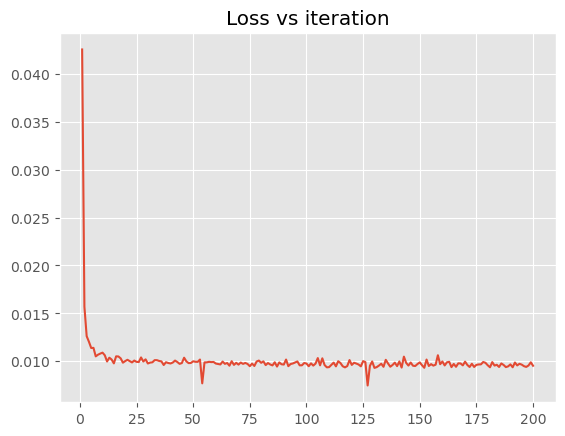

In [19]:
style.use('ggplot')
plt.plot(range(1, epochs+1), losses)
plt.title("Loss vs iteration")
plt.show()

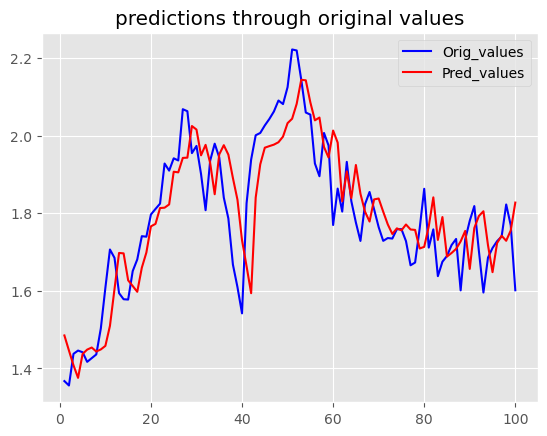

In [20]:
model.eval()
preds = torch.tensor(x, dtype=torch.float32).to(device)
preds = model(preds).detach().numpy()
preds = preds.reshape(preds.shape[0])

style.use('ggplot')
plt.plot(range(1, 101), y[-100:], 'b')
plt.plot(range(1, 101), preds[-100:], 'r')
plt.title("predictions through original values")
plt.legend(['Orig_values', 'Pred_values'])
plt.show()
# gets pretty close but let us try forecasting

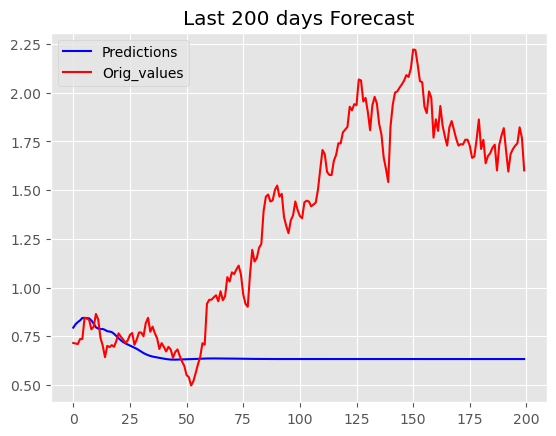

In [21]:
index, window_len, num_samples = -220, 20, 200 # index = -(window_len + num_samples)
predictions = forecast(index, window_len, num_samples)
slice_ = stock_values[-num_samples:]

style.use('ggplot')
plt.plot(range(num_samples), predictions, 'b')
plt.plot(range(num_samples), slice_, 'r')
plt.title(f"Last {num_samples} days Forecast")
plt.legend(['Predictions', 'Orig_values'])
plt.show()

* Let us try out training by RandomForestRegressor

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
window_len = 20
x, y = sliding_windows(window_len, stock_values)
model = RandomForestRegressor()
model.fit(x, y)

RandomForestRegressor()

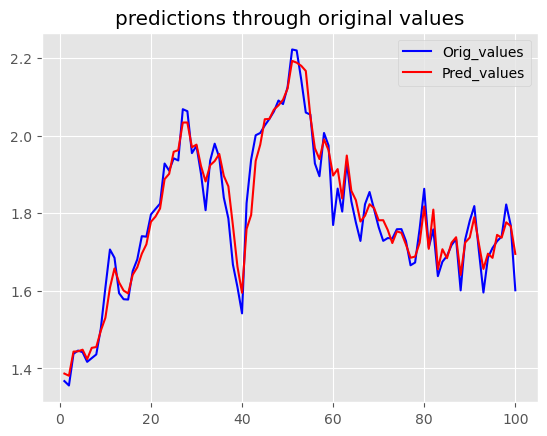

In [24]:
#preds = torch.tensor(x, dtype=torch.float32).to(device)
preds = model.predict(x)
#preds = preds.reshape(preds.shape[0])

style.use('ggplot')
plt.plot(range(1, 101), y[-100:], 'b')
plt.plot(range(1, 101), preds[-100:], 'r')
plt.title("predictions through original values")
plt.legend(['Orig_values', 'Pred_values'])
plt.show()
# gets pretty close but let us try forecasting

In [25]:
# predictions on last 100 of the sequence
def forecast(index=-200, window_len=100, num_samples=100):
    init_data = stock_values[index:index+window_len]
    init_data = np.reshape(init_data, (1, window_len))
    predictions = []
    for i in range(num_samples):
        pred = model.predict(init_data) # shape will be (1,1)
        predictions.append(pred[0])
        init_data = np.concatenate([init_data[:, 1:], pred.reshape(1, 1)], axis=1)
    return predictions

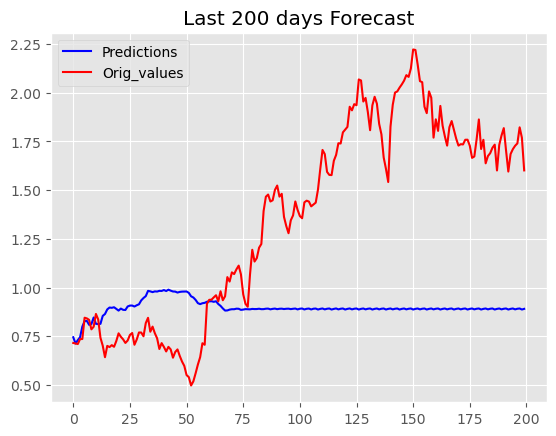

In [26]:
index, window_len, num_samples = -220, 20, 200 # index = -(window_len + num_samples)
predictions = forecast(index, window_len, num_samples)
slice_ = stock_values[-num_samples:]

style.use('ggplot')
plt.plot(range(num_samples), predictions, 'b')
plt.plot(range(num_samples), slice_, 'r')
plt.title(f"Last {num_samples} days Forecast")
plt.legend(['Predictions', 'Orig_values'])
plt.show()

* Let us try one more

In [27]:
window_len = 100
x, y = sliding_windows(window_len, stock_values)
model = RandomForestRegressor()
model.fit(x, y)

RandomForestRegressor()

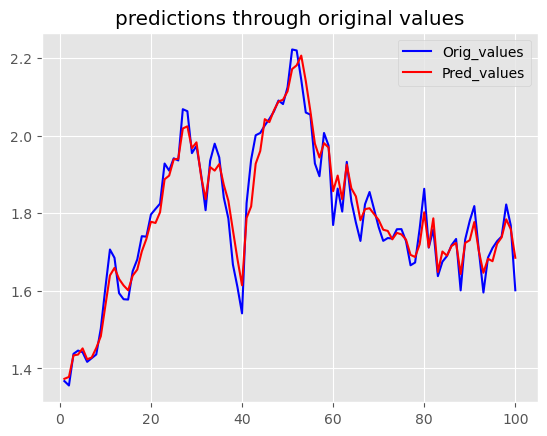

In [28]:
#preds = torch.tensor(x, dtype=torch.float32).to(device)
preds = model.predict(x)
#preds = preds.reshape(preds.shape[0])

style.use('ggplot')
plt.plot(range(1, 101), y[-100:], 'b')
plt.plot(range(1, 101), preds[-100:], 'r')
plt.title("predictions through original values")
plt.legend(['Orig_values', 'Pred_values'])
plt.show()
# gets pretty close but let us try forecasting

In [29]:
# predictions on last 100 of the sequence
def forecast(index=-200, window_len=100, num_samples=100):
    init_data = stock_values[index:index+window_len]
    init_data = np.reshape(init_data, (1, window_len))
    predictions = []
    for i in range(num_samples):
        pred = model.predict(init_data) # shape will be (1,1)
        predictions.append(pred[0])
        init_data = np.concatenate([init_data[:, 1:], pred.reshape(1, 1)], axis=1)
    return predictions

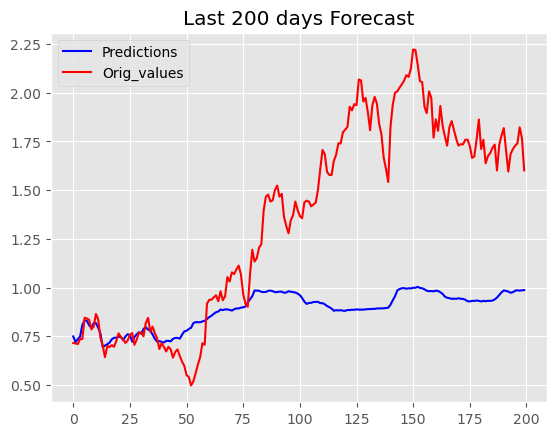

In [30]:
index, window_len, num_samples = -300, 100, 200 # index = -(window_len + num_samples)
predictions = forecast(index, window_len, num_samples)
slice_ = stock_values[-num_samples:]

style.use('ggplot')
plt.plot(range(num_samples), predictions, 'b')
plt.plot(range(num_samples), slice_, 'r')
plt.title(f"Last {num_samples} days Forecast")
plt.legend(['Predictions', 'Orig_values'])
plt.show()